# Climate Analysis - Honolulu Hawaii

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

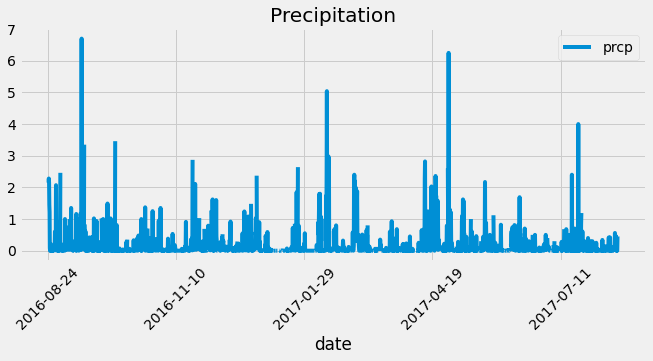

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lastDate = session.query(func.max(measurement.date)).first()[0]
lastDate = dt.datetime.strptime(lastDate, '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
prevYear = lastDate - dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores
result = session.query(measurement.date,measurement.prcp).filter(measurement.date>=prevYear).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(result).set_index('date')

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=45, figsize=(10,4))
plt.title('Precipitation')
plt.savefig("DataImages/Precipitation.png")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(station).count()
print(f"Stations Available: {stations} ")

Stations Available: 9 


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
mostActive = session.query(measurement.station,func.count()).group_by(measurement.station)\
.order_by(func.count().desc()).all()

# most active station string
mActStat = mostActive[0][0]

print(f"The Most Active Stations:")
mostActive

The Most Active Stations:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Finding most active station 
mActStat = mostActive[0][0]
print(f"The Most Active Station: {mActStat}")

The Most Active Station: USC00519281


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

tobs = measurement.tobs
mActStatTemp = session.query(func.min(tobs),func.max(tobs),func.avg(tobs)).\
filter(measurement.station==mActStat).all()

print(f"The Temperatures of the Most Active Station:")
print(f"Low: {mActStatTemp[0][0]} High: {mActStatTemp[0][1]} Average: {round(mActStatTemp[0][2], 1)}")

The Temperatures of the Most Active Station:
Low: 54.0 High: 85.0 Average: 71.7


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station

tobs_max = session.query(tobs).filter(measurement.date >= prevYear).\
    filter(measurement.station == mActStat).\
    order_by(measurement.date).all()

tobs_max = pd.DataFrame(tobs_max, columns=["TOBS"])


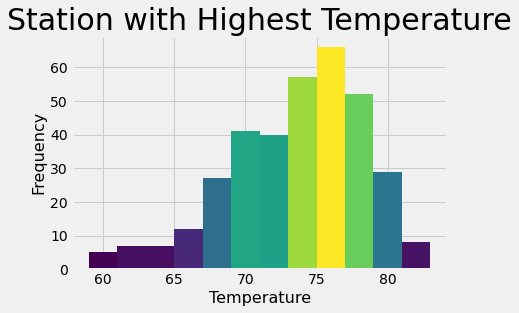

In [17]:
plt.hist(tobs_max["TOBS"], bins = 12,)

plt.title("Station with Highest Temperature", size = 30)
plt.xlabel("Temperature", size = 16)
plt.ylabel("Frequency", size = 16)
N,bins,patches = plt.hist(tobs_max["TOBS"], bins = 12)

# Color code by height
fracs = N / N.max()

# For full range of colours - normalize the data to 0..1 
norm = colors.Normalize(fracs.min(), fracs.max())

# Loop through objects and set the color
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.savefig("DataImages/Station with Highest Temp.png")
plt.show()

## Temperature Analysis II

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(tobs), func.avg(tobs), func.max(tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacay = calc_temps("2016-02-28", "2016-03-05")

print(f"Temperatures for Vacation Dates:")
print(f"Low: {vacay[0][0]} Average: {round(vacay[0][1], 1)} High: {vacay[0][2]}")

Temperatures for Vacation Dates:
Low: 62.0 Average: 69.9 High: 80.0


In [20]:
# Plot the results from your previous query as a bar chart. 
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

vacay_df = pd.DataFrame(vacay, columns=["TMIN", "TAVG", "TMAX"])
vacay_df

,TMIN,TAVG,TMAX
0,62.0,69.886364,80.0


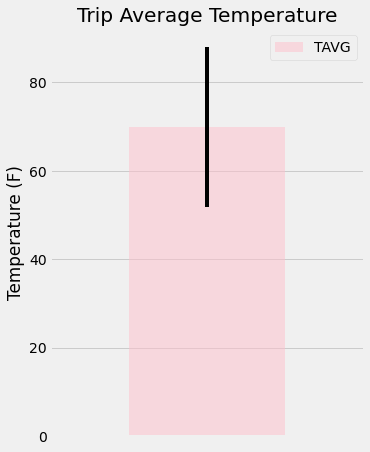

In [21]:
vacay_df = pd.DataFrame(vacay, columns=["TMIN", "TAVG", "TMAX"])
vacay_df.plot.bar(y="TAVG", yerr=(vacay_df["TMAX"] - vacay_df["TMIN"]), title="Trip Average Temperature", 
                  color="pink", alpha=0.5, figsize=(5,7))
plt.ylabel("Temperature (F)")
plt.xticks([])
plt.savefig("DataImages/Trip Average Temperature.png")
plt.show()

In [22]:
def calc_prcp(start_date, end_date):
    return session.query(func.min(measurement.prcp), func.avg(measurement.prcp), func.max(measurement.prcp)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function
vacay_prcp = calc_prcp('2017-02-28', '2017-03-05')

print(f"Precipitation for Vacation Dates:")
print(f"Low: {vacay_prcp[0][0]} Average: {round(vacay_prcp[0][1], 1)} High: {vacay_prcp[0][2]}")

Precipitation for Vacation Dates:
Low: 0.0 Average: 0.7 High: 2.4


In [23]:
start_date = '2017-02-28'
end_date = '2017-03-05'

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(station.name, measurement.station, measurement.prcp, measurement.date, station.latitude, station.longitude, station.elevation).\
            group_by(station.name).\
            filter(measurement.station == station.station).\
            filter(measurement.date >= start_date).filter(measurement.date <= end_date).\
            order_by(measurement.prcp.desc()).all()

In [25]:
# Rainfall per weather station results displayed in DF
rainfall_df = pd.DataFrame(rainfall, 
                           columns=['Name','Station', 'Prcp', 'Date','Latitude', 'Longitude','Elevation']).\
                           set_index('Name')
rainfall_df

,Station,Prcp,Date,Latitude,Longitude,Elevation
Name,,,,,,
"MANOA LYON ARBO 785.2, HI US",USC00516128,0.58,2017-02-28,21.33310,-157.80250,152.4
"KANEOHE 838.1, HI US",USC00513117,0.16,2017-02-28,21.42340,-157.80150,14.6
"WAIHEE 837.5, HI US",USC00519281,0.04,2017-02-28,21.45167,-157.84889,32.9
"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,0.04,2017-02-28,21.52130,-157.83740,7.0
"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,0.00,2017-02-28,21.33556,-157.71139,19.5
"WAIKIKI 717.2, HI US",USC00519397,0.00,2017-02-28,21.27160,-157.81680,3.0
"PEARL CITY, HI US",USC00517948,NaN,2017-02-28,21.39340,-157.97510,11.9


### Daily Rainfall Average

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(tobs), func.avg(tobs), func.max(tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip

start_date = '2017-02-28'
end_date = '2017-03-05' 
my_trip = ['02-28', '03-01', '03-02', '03-03', '03-04', '03-05']

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []

for day in my_trip:
    date = {}
    date['Date'] = '{}'.format(day)
    d_norm = daily_normals(day)
    date['Min'] = d_norm[0][0]
    date['Avg'] = round(d_norm[0][1],1)
    date['Max'] = d_norm[0][2]
    normals.append(date)

for norm in normals:
    print(norm)

{'Date': '02-28', 'Min': 65.0, 'Avg': 70.7, 'Max': 80.0}
{'Date': '03-01', 'Min': 64.0, 'Avg': 70.0, 'Max': 76.0}
{'Date': '03-02', 'Min': 61.0, 'Avg': 70.4, 'Max': 78.0}
{'Date': '03-03', 'Min': 60.0, 'Avg': 70.1, 'Max': 78.0}
{'Date': '03-04', 'Min': 57.0, 'Avg': 69.3, 'Max': 77.0}
{'Date': '03-05', 'Min': 60.0, 'Avg': 67.9, 'Max': 76.0}


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df = pd.DataFrame(normals).set_index('Date')
daily_norms_df

,Min,Avg,Max
Date,,,
02-28,65.0,70.7,80.0
03-01,64.0,70.0,76.0
03-02,61.0,70.4,78.0
03-03,60.0,70.1,78.0
03-04,57.0,69.3,77.0
03-05,60.0,67.9,76.0


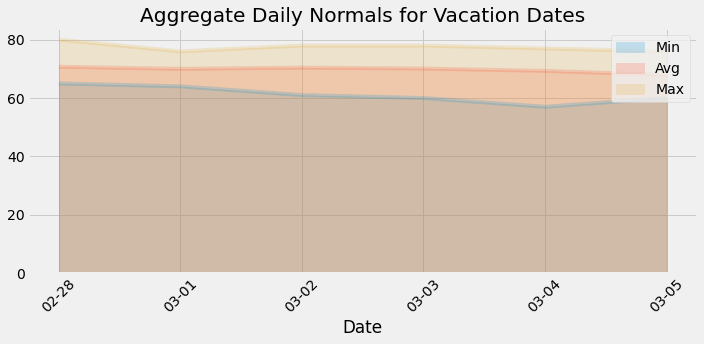

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norms_df.plot(kind='area', alpha=0.2, stacked=False, 
                    figsize=(10,5), rot = 45, title="Aggregate Daily Normals for Vacation Dates")
plt.tight_layout()
plt.legend(loc = "upper right", fontsize = "14")
plt.savefig("DataImages/DailyNormals.png")
plt.show()